In [1]:
import numpy as np

import torch
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
import torch.utils.data as data_utils
from torch.utils.data import DataLoader

import time

import random

import matplotlib.pyplot as plt

Прежде чем начать работу с датасетом, приведем его в необходимый вид: извлечем изображения из архива, перемешаем внутри классов и разобьем на тестовую, валидационную и тренировочную выборки в заданном соотношении.

In [ ]:
# разархивируем файл

import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Bostongene_Intern_test/images_styles.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Bostongene_Intern_test/")

In [ ]:
import os
classes = os.listdir('/content/drive/MyDrive/Bostongene_Intern_test/images') # получаем список папок

In [2]:
start_path = "/content/drive/MyDrive/Bostongene_Intern_test/images/"

In [ ]:
train_part = 0.7 # процент изображений для обучения
val_part = 0.15 # процент изображений для валидации (для теста остается 0.2)

for folder in classes: # в цикле от первой до последней папки
    path = start_path + str(folder) # получаем директорию i-ой папки
    os.chdir(path) # перемещаемся в директорию i-ой папки
    path_files = os.listdir(path) # получаем список файлов i-ой папки
    print(folder, path_files)
    random.shuffle(path_files) # перемешиваем картинки в данной папке
    print(folder, "shuffled", path_files)

    os.makedirs(start_path + 'train/' + folder) # создание папки для трейна
    os.makedirs(start_path + 'val/' + folder) # создание папки для трейна
    os.makedirs(start_path + 'test/' + folder) # создание папки для теста
 
    for idx_img_name, img_name in enumerate(path_files): # цикле от первого до последнего файла i-ой папки
      if idx_img_name < int(train_part * len(path_files)) : # заполняем папку train
        os.rename(path + '/' + img_name, start_path + str('train/') + folder + '/' + img_name)
      elif idx_img_name < int((train_part + val_part) * len(path_files)): # заполняем папку val
        os.rename(path + '/' + img_name, start_path + str('val/') + folder + '/' + img_name)
      else: # заполняем папку test
        os.rename(path + '/' + img_name, start_path + str('test/') + folder + '/' + img_name)
    
    os.rmdir(path) # удаляем папку, из которой файлы уже были извлечены

ArtDeco ['tamara-de-lempicka_still-life-with-grapes.jpg', 'erte_costume-design-2.jpg', 'erte_opium-mah-jongg.jpg', 'bernardo-marques_fernanda-de-castro-cidade-em-flor-capa-1924.jpg', 'erte_stolen-kisses.jpg', 'erte_the-kiss.jpg', 'tamara-de-lempicka_portrait-of-the-duchess-of-la-salle-1925.jpg', 'bernardo-marques_antonio-ferro-mundo-novo-capa.jpg', 'zinaida-serebriakova_still-life-with-apples-and-a-round-bread-1948.jpg', 'aleksandra-ekster_woman-with-fish-1934.jpg', 'tamara-de-lempicka_wide-brimmed-hat-1933.jpg', 'erte_number-8.jpg', 'raphael-delorme_vitalit.jpg', 'zinaida-serebriakova_basket-with-grapes-and-peaches-1931.jpg', 'erte_winter-resort-nice.jpg', 'erte_the-seasons-spring-1.jpg', 'tamara-de-lempicka_calla-lillies-1941.jpg', 'carlos-saenz-de-tejada_sketch-for-decoration-of-carmen-antonia-merce-la-argentina-1927.jpg', 'lawren-harris_lake-and-mountains-1928.jpg', 'john-vassos_modern-abstract-1.jpg', 'john-vassos_abstract-sailboat.jpg', 'erte_blossom-umbrella.jpg', 'erte_the-mirr

In [165]:
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
TRAIN_DATA_PATH = start_path + "train/"
VAL_DATA_PATH = start_path + "val/"
TEST_DATA_PATH = start_path + "test/"

# датасет достаточно мал и содержит около 1500 изображений
# чтобы уменьшить вероятность переобучения, мы добавим аугментацию изображений
# в тренировочном датасете в виде обрезки, переворотов, наклонов и т.д.

train_transformation = transforms.Compose(
    [
     transforms.RandomRotation(15),
     transforms.RandomHorizontalFlip(),
     transforms.RandomResizedCrop(224),
     transforms.Resize((256,256)), # для улучшения результатов трансформируем изображения не в 64*64 или 128*128, а в 256*256
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ]
)

val_transformation = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ]
)

In [166]:
# создаем лоадеры для данных

train_data = torchvision.datasets.ImageFolder(root = TRAIN_DATA_PATH, transform = train_transformation)
train_data_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True,  num_workers=2)

val_data = torchvision.datasets.ImageFolder(root = VAL_DATA_PATH, transform = val_transformation)
val_data_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root = TEST_DATA_PATH, transform = val_transformation)
test_data_loader  = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True, num_workers=2) 

Датасет достаточно маленький и одной аугментации для того, чтобы избавиться от переобучения нам не хватит. В данной тетрадке не отображено, но были опробованы модели MLP, LeNet для классификации изображений, но обучение каждой из моделей оканчивалось оверфиттингом и точностью на тестовой выборке в ~30%. \
Потому решать задачу будем с помощью Transfer learning. Для этого возьмем предобученную модель resnet, а потом заменим классификатор на выходе и переучим его на наши изображения.

In [167]:
# 
model = models.resnet152(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [168]:
for parameter in model.parameters():
  parameter.requires_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(512, 8)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.fc = classifier

In [169]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [170]:
!nvidia-smi

Thu May 27 20:43:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |   6648MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [171]:
optimizer = optim.Adam(model.fc.parameters(), lr = LEARNING_RATE)
criterion = nn.NLLLoss().to(device)

In [172]:
# Создаем функцию для валидации
def validation(model, validateloader, criterion):
  val_loss = 0
  accuracy = 0

  for images, labels in iter(validateloader):
    images, labels = images.to(device), labels.to(device)

    output = model.forward(images)
    val_loss += criterion(output, labels).item()

    probabilities = torch.exp(output)

    equality = (labels.data == probabilities.max(dim=1)[1])
    accuracy += equality.type(torch.FloatTensor).mean()

  return val_loss, accuracy

In [173]:
# Обучаем классификатор

def train_classifier():

    epochs = 35
    steps = 0
    print_every = 40

    epoch_list = []
    
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    model.to(device)

    for e in range(epochs):
      model.train()

      running_loss = 0

      for images, labels in iter(train_data_loader):
        steps+=1

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
          model.eval()

          # отключаем градиенты на валидации, это сэкономит память и время вычислений
          with torch.no_grad():
            validation_loss, accuracy = validation(model, val_data_loader, criterion)

            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Training Loss: {:.3f}".format(running_loss/print_every),
                  "Val Loss: {:.3f}".format(validation_loss/len(val_data_loader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(val_data_loader)))
            
            epoch_list.append(e+1)
            train_loss_list.append(running_loss/print_every)
            val_loss_list.append(validation_loss/len(val_data_loader))
            val_acc_list.append(accuracy/len(val_data_loader))
            
            running_loss = 0
            model.train()
    return epoch_list, train_loss_list, val_loss_list, val_acc_list

In [174]:
epoch_list, train_loss_list, val_loss_list, val_acc_list = train_classifier()

Epoch: 2/35.. Training Loss: 0.397 Val Loss: 1.124 Validation Accuracy: 0.643
Epoch: 3/35.. Training Loss: 0.640 Val Loss: 0.868 Validation Accuracy: 0.722
Epoch: 5/35.. Training Loss: 0.252 Val Loss: 0.786 Validation Accuracy: 0.740
Epoch: 6/35.. Training Loss: 0.546 Val Loss: 0.777 Validation Accuracy: 0.713
Epoch: 8/35.. Training Loss: 0.177 Val Loss: 0.734 Validation Accuracy: 0.727
Epoch: 9/35.. Training Loss: 0.419 Val Loss: 0.672 Validation Accuracy: 0.794
Epoch: 11/35.. Training Loss: 0.159 Val Loss: 0.665 Validation Accuracy: 0.783
Epoch: 12/35.. Training Loss: 0.380 Val Loss: 0.647 Validation Accuracy: 0.769
Epoch: 14/35.. Training Loss: 0.141 Val Loss: 0.623 Validation Accuracy: 0.787
Epoch: 15/35.. Training Loss: 0.313 Val Loss: 0.649 Validation Accuracy: 0.786
Epoch: 17/35.. Training Loss: 0.114 Val Loss: 0.614 Validation Accuracy: 0.793
Epoch: 18/35.. Training Loss: 0.304 Val Loss: 0.605 Validation Accuracy: 0.790
Epoch: 20/35.. Training Loss: 0.094 Val Loss: 0.636 Valida

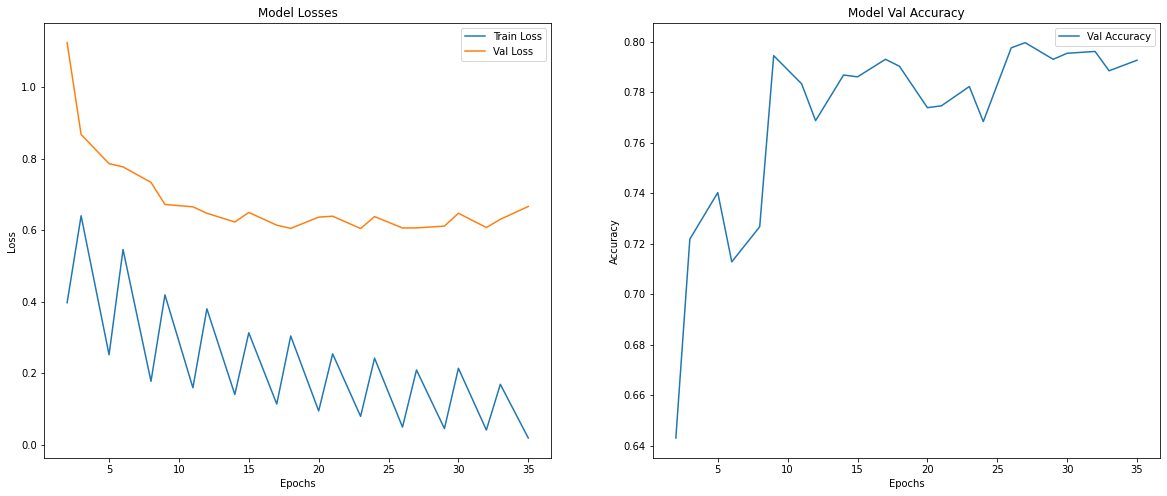

In [175]:
# построим графики
plt.figure(figsize=(20,8))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "Train Loss")
plt.plot(epoch_list, val_loss_list, label = "Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Losses")
plt.legend()

plt.subplot(122)
plt.plot(epoch_list, val_acc_list, label = "Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Val Accuracy")
plt.legend()

In [176]:
# оценим результат на тестовой выборке
def test_accuracy(model, test_loader):

  model.eval()
  model.to(device)

  with torch.no_grad():

    accuracy = 0

    for images, labels in iter(test_loader):
      images, labels = images.to(device), labels.to(device)
      output = model.forward(images)
      probabilities = torch.exp(output)
      equality = (labels.data == probabilities.max(dim=1)[1])
      accuracy += equality.type(torch.FloatTensor).mean()

    print("Test Accuracy: {}".format(accuracy/len(test_loader)))

In [177]:
test_accuracy(model, test_data_loader)

Test Accuracy: 0.7787036895751953


Если сравнить результат с LeNet и MLP нейросетями, то можно с уверенностью сказать, что точность на тестовой выборке выросла более чем в 2.5 раза (было ~30%) + мы избавились от оверфиттинга (см графики обучения: лосс + accuracy). \
На таком маленьком датасете это хороший результат!